In [10]:
import semra
import pyobo
import pandas as pd
import bioregistry
import bioversions
from semra.io import from_sssom, from_pickle
from semra.api import get_index
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import math
import semra.api
from IPython.display import SVG
import itertools as itt

from disease import CONFIGURATION, MODULE

## Summarize the Resources

In [2]:
terms = {
    prefix: pyobo.get_id_name_mapping(prefix)
    for prefix in CONFIGURATION.priority
}

In [3]:
summary_rows = [
    (prefix, bioregistry.get_license(prefix), bioversions.get_version(prefix), len(terms[prefix]))
    for prefix in CONFIGURATION.priority
]
summary_df = pd.DataFrame(summary_rows, columns=["prefix", "license", "version", "terms"])
summary_df

,prefix,license,version,terms
0,doid,CC0-1.0,2024-02-28,11511
1,mondo,CC-BY-4.0,2024-03-04,24099
2,efo,Apache-2.0,3.63.0,16410
3,mesh,CC0-1.0,2024,354069
4,ncit,CC-BY-4.0,24.02d,181982
5,hp,hpo,2024-03-06,18281


## Summarize the Mappings

In [4]:
mappings = from_pickle(MODULE.join(name="processed.pkl"))
processed_n = len(mappings)
processed_n

367726

In [5]:
# Remove many-to-many mappings since it overinflates
#mappings = semra.api.filter_many_to_many(mappings, progress=False)
#filtered_n = len(mappings)
#filtered_n

# TODO filter out many-to-many mappings before starting - 
# using the typical function doesn't work since there is 

In [6]:
index = get_index(mappings)

Indexing mappings:   0%|          | 0.00/368k [00:00<?, ?mapping/s]

In [7]:
directed = defaultdict(set)
for s, p, o in index:
    if p != semra.EXACT_MATCH:
        continue
    directed[s.prefix, o.prefix].add(s.identifier)
    directed[o.prefix, s.prefix].add(o.identifier)

### Asymmetric Summarization

The following summary looks for each ordered pair of resources, what percentage of each resources' terms are mapped to the other resource. Because each resource is a different size, this is an asymmetric measurement.

The way to read this table is the horizontal index corresponds to the source prefix and the columns correspond to the target prefix. This means in the row with label "efo" and column with label "mesh" that has 14% means that 14% of EFO can be mapped to MeSH.

In [14]:
def _df(xx, default=1.0):
    rows = [
        [xx[p1, p2] if p1 != p2 else default for p2 in CONFIGURATION.priority]
        for p1 in CONFIGURATION.priority
    ]
    df = pd.DataFrame(rows, columns=CONFIGURATION.priority, index=CONFIGURATION.priority)
    df.index.name = 'source_prefix'
    df.columns.name = 'target_prefix'
    return df

In [34]:
asymmetric = {
    (l, r): len(l_entities.intersection(terms[l])) / len(terms[l])
    for (l, r), l_entities in directed.items()
}
asymmetric_summary_df = _df(asymmetric)
asymmetric_summary_df.round(2) * 100

target_prefix,doid,mondo,efo,mesh,ncit,hp
source_prefix,,,,,,
doid,100.0,97.0,21.0,24.0,49.0,5.0
mondo,48.0,100.0,14.0,35.0,32.0,4.0
efo,15.0,19.0,100.0,13.0,19.0,3.0
mesh,1.0,2.0,1.0,100.0,1.0,0.0
ncit,3.0,4.0,2.0,2.0,100.0,0.0
hp,4.0,5.0,3.0,3.0,4.0,100.0


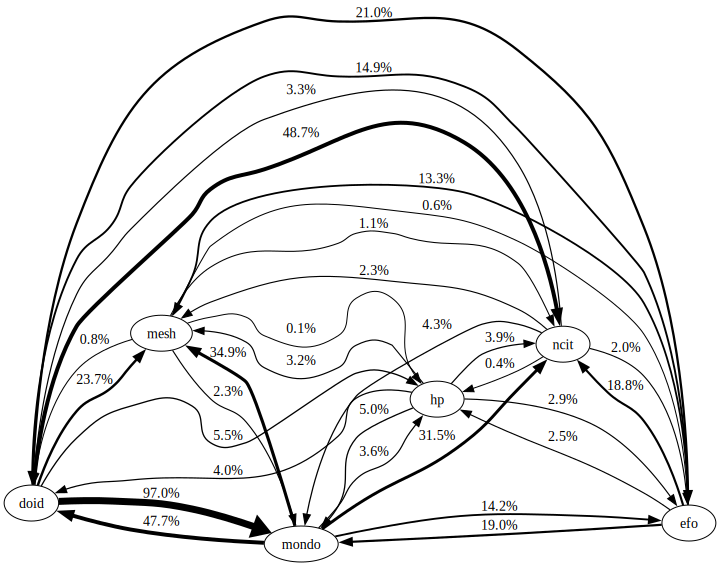

In [44]:
graph = nx.DiGraph()
for (s, t), count in asymmetric.items():
    graph.add_edge(s, t, weight=count, label=f"{count:.1%}")

agraph = nx.nx_agraph.to_agraph(graph)
agraph.graph_attr["rankdir"] = "LR"

bottom, top = min(asymmetric.values()), max(asymmetric.values())
rr = top - bottom

for edge, weight in asymmetric.items():
    x = 1 + 6 * (weight - bottom) / rr
    agraph.get_edge(*edge).attr['penwidth'] = x

svg = agraph.draw(prog="dot", format='svg')
SVG(svg)

### Symmetric Summarization

In [33]:
# intersect with the terms for each to make sure we're not keeping any mappings that are irrelevant

symmetric = {
    (l, r): (
        max(len(directed[l, r].intersection(terms[l])), len(directed[r, l].intersection(terms[l]))) 
        / min(len(terms[r]), len(terms[l]))
    )
    for l, r in directed
}

symmetric_df = _df(symmetric)

# clip since there might be some artifacts of mappings to terms that don't exist anymore
symmetric_df.round(2) * 100

target_prefix,doid,mondo,efo,mesh,ncit,hp
source_prefix,,,,,,
doid,100.0,97.0,21.0,24.0,49.0,5.0
mondo,100.0,100.0,21.0,35.0,32.0,5.0
efo,21.0,19.0,100.0,13.0,19.0,3.0
mesh,25.0,34.0,14.0,100.0,2.0,3.0
ncit,52.0,32.0,22.0,2.0,100.0,4.0
hp,6.0,5.0,3.0,3.0,4.0,100.0


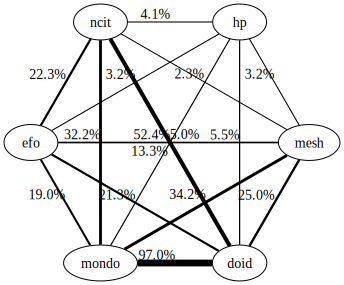

In [43]:
graph = nx.Graph()
for (s, t), count in symmetric.items():
    graph.add_edge(s, t, weight=count, label=f"{count:.1%}")

agraph = nx.nx_agraph.to_agraph(graph)
agraph.graph_attr["rankdir"] = "LR"

bottom, top = min(symmetric.values()), max(symmetric.values())
rr = top - bottom

for edge, weight in symmetric.items():
    x = 1 + 6 * (weight - bottom) / rr
    agraph.get_edge(*edge).attr['penwidth'] = x

# Note that this includes potential many-to-many mappings
SVG(agraph.draw(prog="dot", format='svg'))